In [118]:
import pandas as pd
import numpy as np
import requests
import os
from pathlib import Path
from dotenv import load_dotenv

### Import S&P 500

In [2]:
# Import historical S&P 500 data (csv)
sp500_path = Path("resources/^GSPC.csv")  # Source: Yahoo Finance (https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325635200&period2=1597708800&interval=1d&filter=history&frequency=1d)
sp500_df = pd.read_csv(sp500_path)
sp500_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
23262,2020-08-11,3370.340088,3381.010010,3326.439941,3333.689941,3333.689941,5087650000
23263,2020-08-12,3355.459961,3387.889893,3355.459961,3380.350098,3380.350098,3768560000
23264,2020-08-13,3372.949951,3387.239990,3363.350098,3373.429932,3373.429932,3648810000
23265,2020-08-14,3368.659912,3378.510010,3361.639893,3372.850098,3372.850098,3193400000
23266,2020-08-17,3380.860107,3387.590088,3379.219971,3381.989990,3381.989990,3671290000


In [14]:
# Clean historical S&P 500
# sp500_df = sp500_df.set_index('Date')
sp500_daily_historical = sp500_df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])
sp500_daily_historical = sp500_daily_historical.rename(columns={'Adj Close':'S&P 500'})
sp500_daily_historical = sp500_daily_historical.round(2)
sp500_daily_historical = sp500_daily_historical[:-3]
sp500_daily_historical['Date'] = pd.to_datetime(sp500_daily_historical['Date'])
sp500_daily_historical = sp500_daily_historical.set_index('Date')
# sp500_daily_historical.tail(3)

S&P 500    0
dtype: int64

In [55]:
# Get most recent S&P 500 data 
import pandas_datareader.data as web
import datetime

# last_historical_day = sp500_daily_historical.iloc[-1]['Date']
# start = datetime.datetime.strptime(last_historical_day, '%Y-%m-%d').date()
# end = datetime.date.today()
sp500_current = web.DataReader(['sp500'], 'fred')
sp500_current = sp500_current.reset_index()
sp500_current = sp500_current.rename(columns={'DATE':'Date', 'sp500':'S&P 500'})
sp500_current = sp500_current.set_index('Date')
sp500_current = sp500_current.dropna()
sp500_current.info()
# print(start, end)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2015-08-24 to 2020-08-21
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S&P 500  1259 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


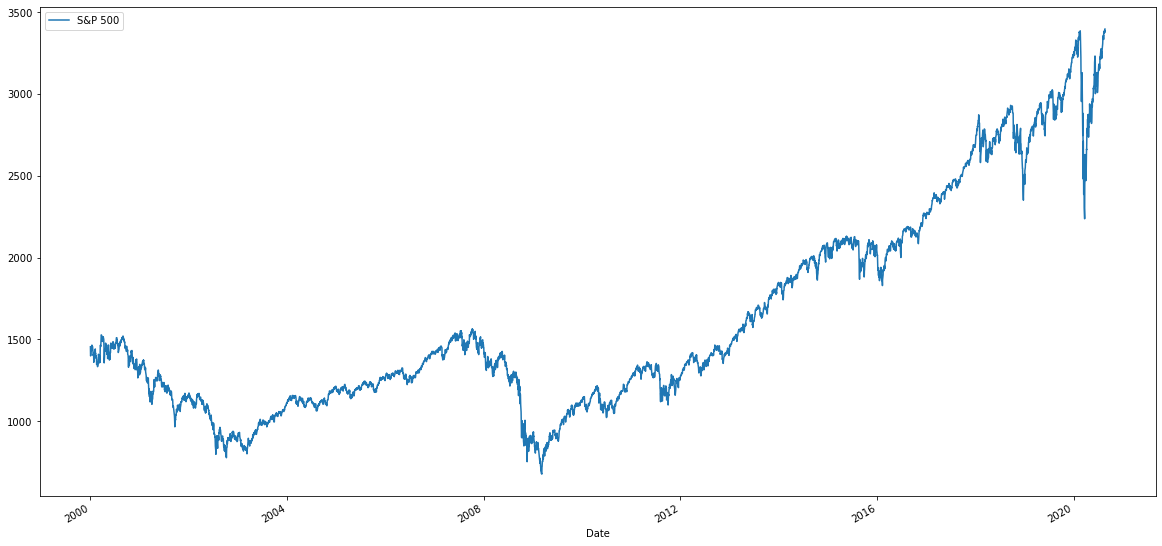

In [234]:
# Combine Historical S&P and Most recent S&P
sp500_daily = pd.concat([sp500_daily_historical, sp500_current], axis=0, join='outer')
# sp500_daily = pd.merge(sp500_daily_historical, sp500_current, left_on= ['Date', 'S&P 500'],
#                    right_on= ['DATE', 'sp500'], how='outer')
sp500_daily = sp500_daily.loc['2000':]
sp500_daily.plot(figsize=(20,10))

In [235]:
sp500_daily.head()

,S&P 500
Date,
2000-01-03,1455.22
2000-01-04,1399.42
2000-01-05,1402.11
2000-01-06,1403.45
2000-01-07,1441.47


In [237]:
# Check if combined properly (Check if duplicate date)

# sp500_daily = sp500_daily.reset_index()
# sp500_daily[sp500_daily.duplicated(['Date'])]
# sp500_daily['Date'] = sp500_daily['Date'].drop_duplicates()
# sp500_daily = sp500_daily.set_index('Date')


# Drop rows with duplicated datetime index
sp500_daily['index'] = sp500_daily.index
sp500_daily= sp500_daily.drop_duplicates('index')
sp500_daily.set_index = sp500_daily['index']
sp500_daily= sp500_daily.drop('index', axis =1)

sp500_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5193 entries, 2000-01-03 to 2020-08-21
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S&P 500  5193 non-null   float64
dtypes: float64(1)
memory usage: 81.1 KB


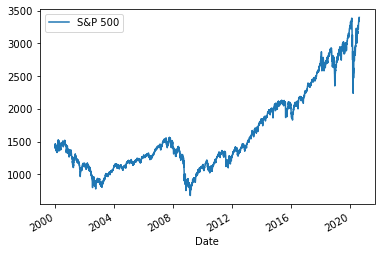

In [238]:
# sp500_daily.head()
sp500_daily.plot()

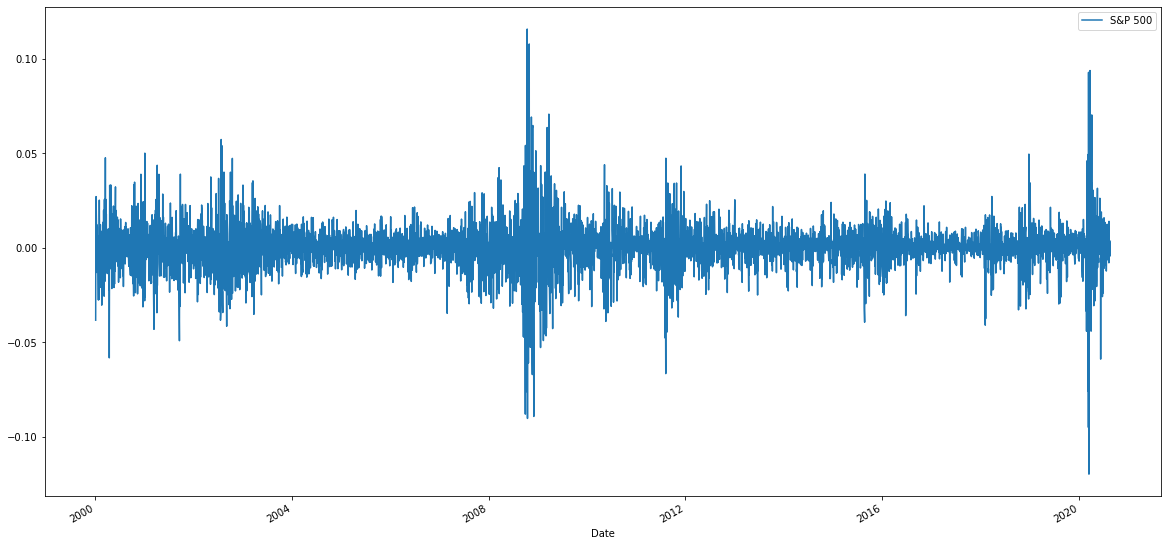

In [239]:
# Calculate Daily Returns - S&P 500
sp500_returns = sp500_daily.pct_change()
sp500_returns = sp500_returns.dropna()
sp500_returns.plot(figsize=(20,10))

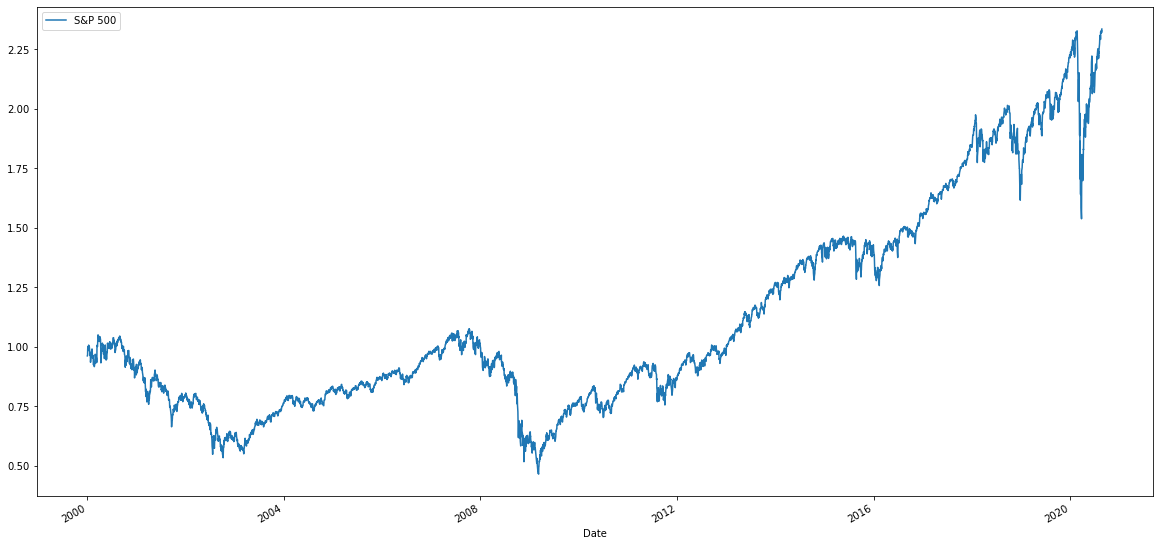

In [240]:
# Calculate Cumulative Returns - S&P 500
sp500_cum_returns = (1+sp500_returns).cumprod()
sp500_cum_returns.plot(figsize=(20,10))

In [241]:
# Calculate Standard Deviation - S&P 500
sp500_std = sp500_returns.std()
sp500_std

S&P 500    0.012549
dtype: float64

### Import Alpha Vantage Stocks

In [60]:
load_dotenv()

True

In [61]:
# Get alpha-vantage api key
alphavantage_api_key = os.getenv("ALPHAVANTAGE_API_KEY")
type(alphavantage_api_key)

str

In [62]:
# import alpha-vantage
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.timeseries import TimeSeries

ts = TimeSeries(key=alphavantage_api_key, output_format='pandas')

In [63]:
def get_daily(quote):
    """GET stock's daily adjusted data using alpha vantage api """
    data, meta_data = ts.get_daily_adjusted(quote, outputsize='full')
    data = data.sort_index(ascending=True)
    return data

In [147]:
def setup_adjusted_close(quote, stock_data):
    """Clean stock data: drop col, rename col"""
    stock_data = stock_data.drop(columns=['1. open', '2. high', '3. low', '4. close',
           '6. volume', '7. dividend amount', '8. split coefficient'])
    stock_data = stock_data.rename(columns = {'5. adjusted close':quote})
    stock_data.index.names = ['Date']
    #     stock_data.dropna(inplace=True)
    return stock_data

In [144]:
# Get stock data from Alpha Vantage
EA_data = get_daily('EA')
TTWO_data = get_daily('TTWO')
ATVI_data = get_daily('ATVI')

In [148]:
# Prepare Data
EA_daily = setup_adjusted_close('EA', EA_data)
TTWO_daily = setup_adjusted_close('TTWO', TTWO_data)
ATVI_daily = setup_adjusted_close('ATVI', ATVI_data)

In [167]:
EA_daily.duplicated()

Date
1999-11-01    False
1999-11-02    False
1999-11-03    False
1999-11-04     True
1999-11-05    False
              ...  
2020-08-17    False
2020-08-18    False
2020-08-19    False
2020-08-20     True
2020-08-21    False
Length: 5236, dtype: bool

In [168]:
sp500_daily.duplicated()

Date
2000-01-03    False
2000-01-04    False
2000-01-05    False
2000-01-06    False
2000-01-07    False
              ...  
2020-08-17    False
2020-08-18    False
2020-08-19    False
2020-08-20    False
2020-08-21    False
Length: 6445, dtype: bool

In [243]:
# Concat - Gaming Industry
gaming_industry = pd.concat([EA_daily, TTWO_daily, ATVI_daily, sp500_daily], axis=1, join='inner')
gaming_industry.head(3)

,EA,TTWO,ATVI,S&P 500
Date,,,,
2000-01-03,25.2750,9.1266,1.2279,1455.22
2000-01-04,22.3450,8.8733,1.1906,1399.42
2000-01-05,21.5475,8.8333,1.1950,1402.11


In [244]:
# Check data
gaming_industry.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5193 entries, 2000-01-03 to 2020-08-21
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EA       5193 non-null   float64
 1   TTWO     5193 non-null   float64
 2   ATVI     5193 non-null   float64
 3   S&P 500  5193 non-null   float64
dtypes: float64(4)
memory usage: 202.9 KB


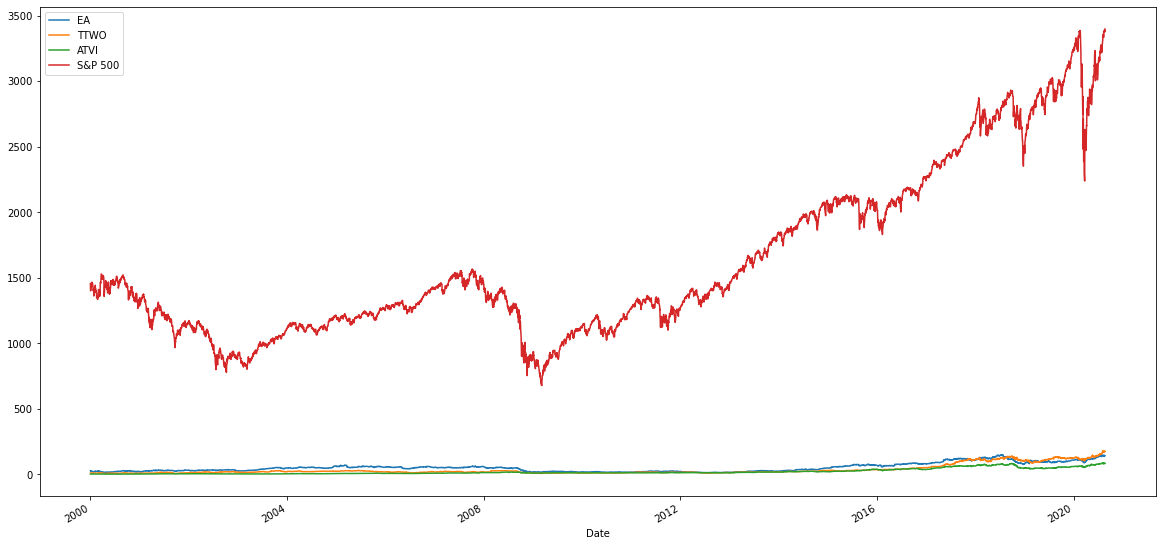

In [245]:
# Plot - Gaming Industry
gaming_industry.plot(figsize=(20,10))

In [246]:
# Calculate Daily Returns - 
gaming_returns = gaming_industry.pct_change()
gaming_returns = gaming_returns.dropna()
gaming_returns.head()

,EA,TTWO,ATVI,S&P 500
Date,,,,
2000-01-04,-0.115925,-0.027754,-0.030377,-0.038345
2000-01-05,-0.035690,-0.004508,0.003696,0.001922
2000-01-06,-0.071818,-0.009057,-0.019331,0.000956
2000-01-07,0.029750,0.028172,0.027391,0.027090
2000-01-10,0.166909,0.018522,0.050914,0.011190


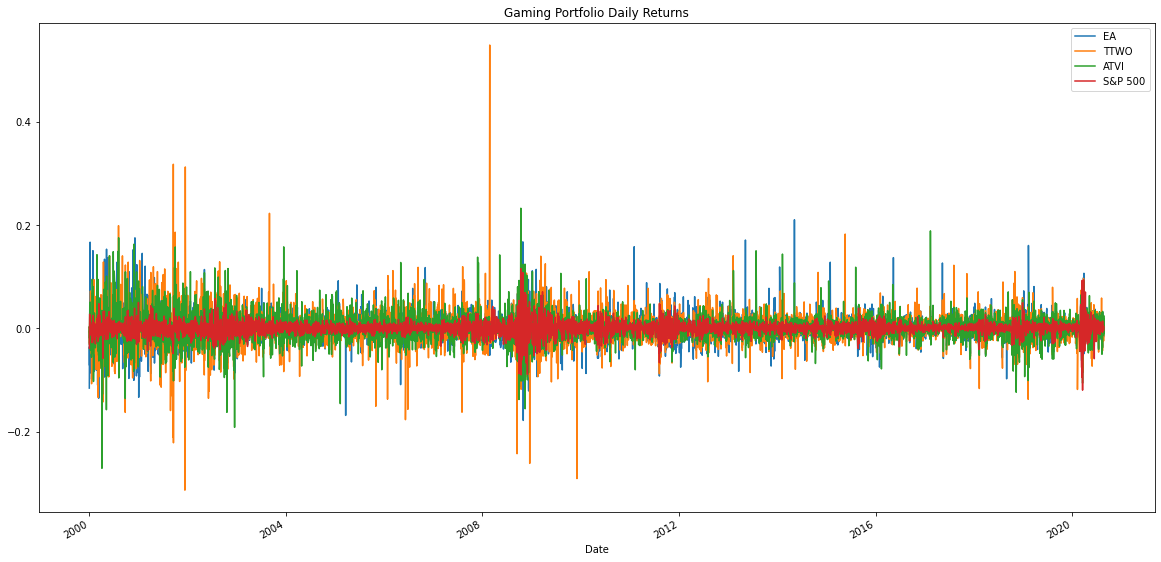

In [247]:
# Plot Daily Returns
gaming_returns.plot(figsize=(20, 10), title="Gaming Portfolio Daily Returns")

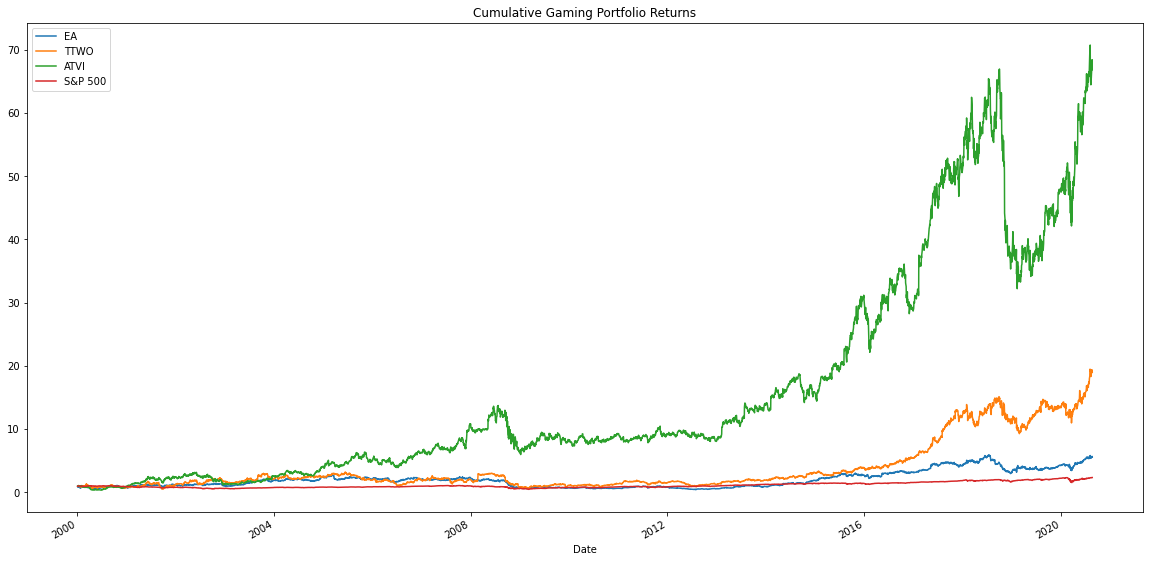

In [249]:
# Plot Cumulative Returns - Gaming Portfolio
gaming_cumulative_returns = (1 + gaming_returns).cumprod()
gaming_cumulative_returns.plot(figsize=(20,10), title="Cumulative Gaming Portfolio Returns")

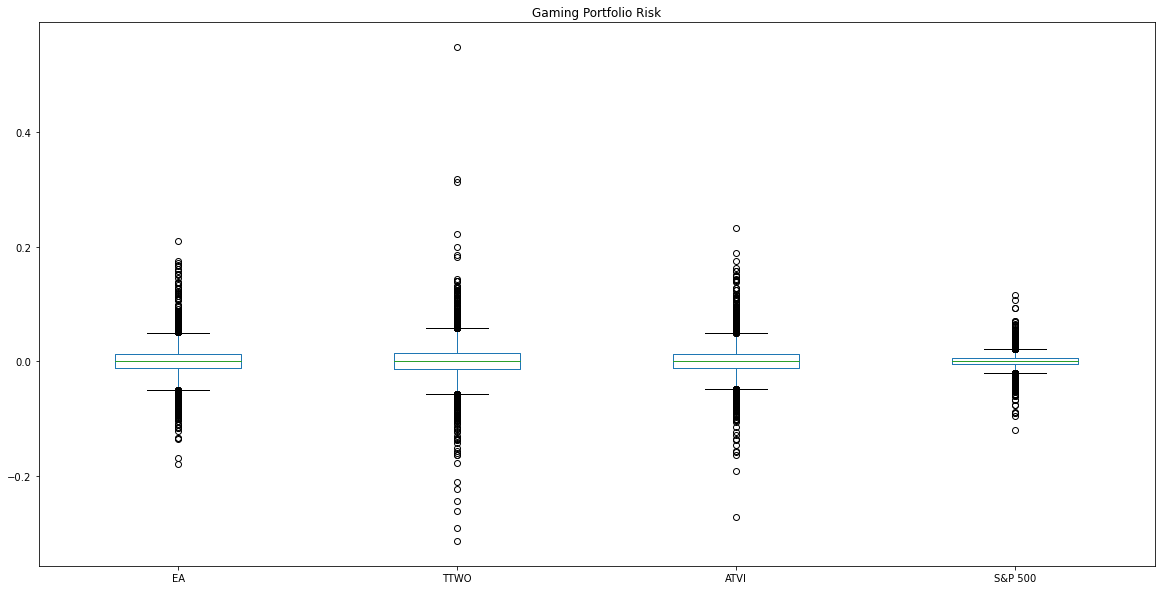

In [250]:
# Box Plot - Daily Returns - Gaming Portfolio
gaming_returns.plot.box(figsize=(20, 10), title="Gaming Portfolio Risk")

In [251]:
# Daily Standard Deviations - Gaming Portfolio
gaming_returns.std()

EA         0.026718
TTWO       0.032686
ATVI       0.026931
S&P 500    0.012549
dtype: float64

In [252]:
# Calculate the annualized standard deviation (252 trading days)
gaming_returns.std() * np.sqrt(252)

EA         0.424142
TTWO       0.518880
ATVI       0.427520
S&P 500    0.199217
dtype: float64

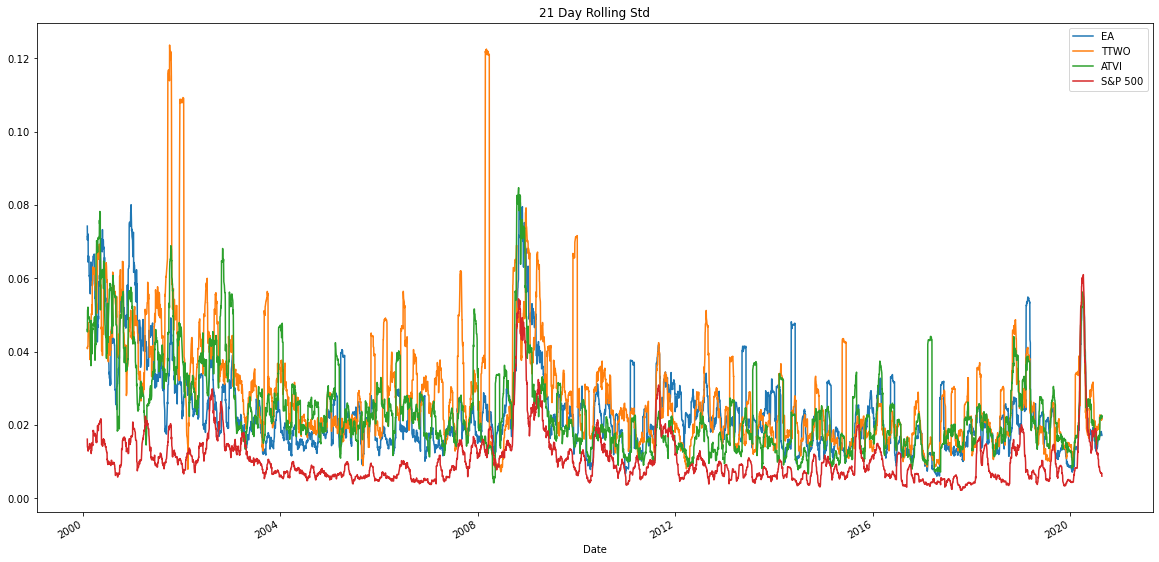

In [253]:
# Rolling Std - Gaming Industry
gaming_returns.rolling(window=21).std().plot(figsize=(20, 10), title="21 Day Rolling Std")

In [255]:
# Correlation table - Gaming Industry
corr_df = gaming_returns.corr()
corr_df.style.background_gradient()

,EA,TTWO,ATVI,S&P 500
EA,1.000000,0.358677,0.454363,0.493836
TTWO,0.358677,1.000000,0.375281,0.391486
ATVI,0.454363,0.375281,1.000000,0.452343
S&P 500,0.493836,0.391486,0.452343,1.000000
